# Mass balance type intercomparison with one flowline for all reference glaciers

In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import netCDF4
import matplotlib.pyplot as plt
import ast
import scipy
import scipy.stats as stats

import oggm

# imports from oggm
from oggm import cfg, utils, workflow, tasks
from oggm.cfg import SEC_IN_YEAR, SEC_IN_MONTH
from oggm.core.massbalance import MassBalanceModel
from oggm.exceptions import InvalidWorkflowError, InvalidParamsError
from oggm.core import climate

# imports from MBsandbox package modules
from MBsandbox.mbmod_daily_oneflowline import process_era5_daily_data, TIModel, BASENAMES
from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq

In [11]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('figure',figsize=(20,10))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
# take only Alpine reference glaciers, all reference glaciers does not work because of init_glacier_directories ...
rgi_version = '61'
#rgi_region = '11'  # Region Central Europe
#path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
#rgidf = gpd.read_file(path)

df, _ = utils.get_wgms_files()
# if for all 
ref_glaciers = df[df['RGI_REG']=='11']['RGI{}0_ID'.format(rgi_version[0])] #[df['RGI_REG']=='11']
# ref_glaciers = df['RGI{}0_ID'.format(rgi_version[0])] #[df['RGI_REG']=='11']

df = utils.get_rgi_glacier_entities(ref_glaciers.values) #, 'RGI-60-11.01238'])

cfg.initialize()
working_dir = '/home/lilianschuster/Schreibtisch/PhD/oggm_files/oneFlowline'
# this needs to be changed if working on another computer
if not os.path.exists(working_dir):
    working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)
    
cfg.PATHS['working_dir'] = working_dir

cfg.PARAMS['baseline_climate'] = 'ERA5_daily'

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

gdirs = workflow.init_glacier_directories(df, from_prepro_level=2, prepro_border=10,
                                          prepro_base_url=base_url, prepro_rgi_version='62')

2021-02-24 09:22:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-24 09:22:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-24 09:22:51: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-24 09:22:51: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `ERA5_daily`.
2021-02-24 09:22:51: oggm.workflow: init_glacier_directories from prepro level 2 on 66 glaciers.
2021-02-24 09:22:51: oggm.workflow: Execute entity task gdir_from_prepro on 66 glaciers


---

In [4]:
# create a pandas dataframe
# this is not the best way to do this:
# better would be a xarray dataset with mb_type+grad & rgi_id as dimensions and DDF_opt and stats(RMSD,bias,rcor,std_quot) as variables 

pd_mb_data = pd.DataFrame(df['RGIId'].values)
pd_mb_data.index = pd_mb_data[0]

for mb_type in ['mb_monthly', 'mb_daily', 'mb_real_daily']:
    for grad in ['cte', 'var_an_cycle']:
        pd_mb_data['DDF_opt_{}_{}'.format(mb_type, grad)] = np.NaN
        pd_mb_data['stats_{}_{}'.format(mb_type, grad)] = np.NaN


### compute how well the mass balance is modelled and plot this for all Alpine reference glaciers

save the optimised DDF, statistics & ...  in pd_mb_data


In [5]:
run = True
pf = 2.5
N = 100 # 5000
if run:
    loop = False
    for gd in gdirs:
        try:
            # need ERA5dr climate if not mb_real_daily 
            cfg.PARAMS['baseline_climate'] = 'ERA5dr'
            oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
            oggm.core.climate.historical_climate_qc(gd)
            mbdf = gd.get_ref_mb_data()
            h, w = gd.get_inversion_flowline_hw()
            plt.figure(figsize=(24,15))
            plt.plot(mbdf.index,mbdf.ANNUAL_BALANCE, label = 'observed', color = 'black', lw = 2)
            for mb_type in ['mb_monthly', 'mb_daily']: 
                for grad in ['cte', 'var_an_cycle']:        
                    gd_mb = TIModel(gd, None,
                                    mb_type=mb_type, grad_type=grad, prcp_fac = 2.5, loop = loop, N = N) 

                    pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)] = scipy.optimize.brentq(minimize_bias,10,10000,
                                                                                                             args=(gd_mb, gd, pf, False),
                                                                                                             disp=True, xtol=0.1)
                    gd_mb.melt_f = pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)]

                    r_h0 = gd_mb.ref_hgt
                    # check climate and adapt if necessary
                    gd_mb.historical_climate_qc_mod(gd)
                    r_h1 = gd_mb.ref_hgt
                    if r_h1 != r_h0:
                        print(gd.rgi_id, r_h1, r_h0, gd.get_diagnostics())
                    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,  year = mbdf.index.values)
                    label_part1 = 'modeled {} {} gradient: '.format(mb_type, grad)
                    pd_mb_data.loc[gd.rgi_id,'stats_{}_{}'.format(mb_type, grad)] = [compute_stat(mb_specific=mb_specific, mbdf=mbdf,
                                                                                                  return_dict = True,
                                                                                                  return_plot=label_part1)]

            # need ERA5_daily climate for mb_real_daily 
            cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
            process_era5_daily_data(gd)
            for mb_type in ['mb_real_daily']:
                for grad in ['cte', 'var_an_cycle']:   
                    gd_mb = TIModel(gd, None,
                                    mb_type=mb_type, grad_type=grad, prcp_fac = 2.5, loop = loop, N = N) 

                    pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)] = scipy.optimize.brentq(minimize_bias,10,10000,
                                                                                                             args=(gd_mb, gd, pf, False),
                                                                                                             disp=True, xtol=0.1)
                    gd_mb.melt_f = pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)]
                    
                    r_h0 = gd_mb.ref_hgt
                    # check climate and adapt if necessary
                    gd_mb.historical_climate_qc_mod(gd)
                    r_h1 = gd_mb.ref_hgt
                    if r_h1 != r_h0:
                        print(gd.rgi_id, r_h1, r_h0, gd.get_diagnostics())
                    
                    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,  year = mbdf.index.values)
                    label_part1 = 'modeled {} {} gradient: '.format(mb_type, grad)
                    pd_mb_data.loc[gd.rgi_id,'stats_{}_{}'.format(mb_type, grad)] = [compute_stat(mb_specific=mb_specific, mbdf=mbdf,
                                                                                                  return_dict=True, 
                                                                                                  return_plot = label_part1)]



            plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');

            plt.xlabel('year')
            plt.title(gd.rgi_id)
            plt.legend()

            plt.savefig('./figures_alps_indiv/mb_one_flowline_{}_N_{}.pdf'.format(gd.rgi_id,N))
            plt.close()
        except:
            print(gd.rgi_id)
            plt.close()

    pd_mb_data.to_csv('stats_Alps_6mb_models_N_{}_with_mean_an_cycle.csv'.format(N), index = False)


2021-02-23 18:11:04: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:11:04: oggm.shop.ecmwf: (RGI60-11.00002) process_ecmwf_data
2021-02-23 18:11:07: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_temp_monthly.nc verified successfully.
2021-02-23 18:11:10: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_totalprecip_monthly.nc verified successfully.
2021-02-23 18:11:13: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_geopotential_monthly.nc verified successfully.
2021-02-23 18:11:25: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.
2021-02-23 18:11:42: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.d

RGI60-11.00012
RGI60-11.00073


2021-02-23 18:11:46: oggm.core.climate: (RGI60-11.00080) historical_climate_qc
2021-02-23 18:11:47: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:11:47: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00080) process_era5_daily_data
2021-02-23 18:11:48: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:11:48: oggm.shop.ecmwf: (RGI60-11.00106) process_ecmwf_data
2021-02-23 18:11:48: oggm.core.climate: (RGI60-11.00106) historical_climate_qc
2021-02-23 18:11:48: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:11:48: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00106) process_era5_daily_data
2021-02-23 18:11:49: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:11:49: oggm.shop.ecmwf: (RGI60-11.00116) process_ecmwf_data
2021-02-23 18:11:50: oggm.core.climate: (RGI60-11.00116) historical_climate_qc
2021-02-23 18:11:50: oggm.cfg: PA

RGI60-11.00929


2021-02-23 18:12:16: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:12:16: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00957) process_era5_daily_data
2021-02-23 18:12:17: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:12:17: oggm.shop.ecmwf: (RGI60-11.01238) process_ecmwf_data
2021-02-23 18:12:17: oggm.core.climate: (RGI60-11.01238) historical_climate_qc
2021-02-23 18:12:18: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:12:18: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01238) process_era5_daily_data
2021-02-23 18:12:18: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:12:18: oggm.shop.ecmwf: (RGI60-11.01367) process_ecmwf_data
2021-02-23 18:12:18: oggm.core.climate: (RGI60-11.01367) historical_climate_qc
2021-02-23 18:12:19: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:1

RGI60-11.02245


2021-02-23 18:12:40: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:12:40: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.02249) process_era5_daily_data
2021-02-23 18:12:41: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:12:41: oggm.shop.ecmwf: (RGI60-11.02285) process_ecmwf_data
2021-02-23 18:12:41: oggm.core.climate: (RGI60-11.02285) historical_climate_qc
2021-02-23 18:12:41: oggm.shop.ecmwf: (RGI60-11.02648) process_ecmwf_data
2021-02-23 18:12:41: oggm.core.climate: (RGI60-11.02648) historical_climate_qc


RGI60-11.02285


2021-02-23 18:12:41: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:12:41: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.02648) process_era5_daily_data
2021-02-23 18:12:42: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:12:42: oggm.shop.ecmwf: (RGI60-11.02671) process_ecmwf_data
2021-02-23 18:12:42: oggm.core.climate: (RGI60-11.02671) historical_climate_qc
2021-02-23 18:12:43: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:12:43: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.02671) process_era5_daily_data
2021-02-23 18:12:44: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:12:44: oggm.shop.ecmwf: (RGI60-11.02679) process_ecmwf_data
2021-02-23 18:12:44: oggm.core.climate: (RGI60-11.02679) historical_climate_qc
2021-02-23 18:12:44: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:1

RGI60-11.03246


2021-02-23 18:13:03: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:13:03: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.03638) process_era5_daily_data
2021-02-23 18:13:04: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:13:04: oggm.shop.ecmwf: (RGI60-11.03643) process_ecmwf_data
2021-02-23 18:13:04: oggm.core.climate: (RGI60-11.03643) historical_climate_qc
2021-02-23 18:13:05: oggm.shop.ecmwf: (RGI60-11.03671) process_ecmwf_data
2021-02-23 18:13:05: oggm.core.climate: (RGI60-11.03671) historical_climate_qc


RGI60-11.03643


2021-02-23 18:13:05: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:13:05: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.03671) process_era5_daily_data
2021-02-23 18:13:06: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:13:06: oggm.shop.ecmwf: (RGI60-11.03674) process_ecmwf_data
2021-02-23 18:13:06: oggm.core.climate: (RGI60-11.03674) historical_climate_qc
2021-02-23 18:13:06: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:13:06: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.03674) process_era5_daily_data
2021-02-23 18:13:07: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:13:07: oggm.shop.ecmwf: (RGI60-11.03756) process_ecmwf_data
2021-02-23 18:13:07: oggm.core.climate: (RGI60-11.03756) historical_climate_qc
2021-02-23 18:13:08: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:1

In [6]:
pd_mb_data = pd.read_csv('stats_Alps_6mb_models_N_{}_with_mean_an_cycle.csv'.format(N))

pd_mb_data


,0,DDF_opt_mb_monthly_cte,stats_mb_monthly_cte,DDF_opt_mb_monthly_var_an_cycle,stats_mb_monthly_var_an_cycle,DDF_opt_mb_daily_cte,stats_mb_daily_cte,DDF_opt_mb_daily_var_an_cycle,stats_mb_daily_var_an_cycle,DDF_opt_mb_real_daily_cte,stats_mb_real_daily_cte,DDF_opt_mb_real_daily_var_an_cycle,stats_mb_real_daily_var_an_cycle
0,RGI60-11.00002,162.348891,"{'RMSD': 85.20067063174596, 'bias': -4.2427121...",131.720620,"{'RMSD': 82.25571633155309, 'bias': -0.0001754...",142.641595,"{'RMSD': 80.36144898732185, 'bias': -1.1368683...",117.565365,"{'RMSD': 86.13417742333498, 'bias': -2.2737367...",144.325392,"{'RMSD': 75.26880464524682, 'bias': 0.00010292...",109.264560,"{'RMSD': 93.59630965324662, 'bias': 0.00018088..."
1,RGI60-11.00012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RGI60-11.00073,333.193329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RGI60-11.00080,249.523230,"{'RMSD': 117.42330087472685, 'bias': 8.5627692...",203.472846,"{'RMSD': 111.11176102232251, 'bias': 0.0001021...",205.258553,"{'RMSD': 106.51681240243217, 'bias': -1.023181...",172.096628,"{'RMSD': 104.63056256683397, 'bias': 4.5474735...",208.064152,"{'RMSD': 96.99916793621264, 'bias': 8.55954981...",163.030793,"{'RMSD': 96.27097743876713, 'bias': 3.80930777..."
4,RGI60-11.00106,242.792525,"{'RMSD': 122.62566425905526, 'bias': -2.775794...",211.521552,"{'RMSD': 112.48340781365498, 'bias': 9.4729835...",205.086453,"{'RMSD': 104.19768150582217, 'bias': -4.547473...",181.363307,"{'RMSD': 98.03605804265699, 'bias': -2.2737367...",204.976777,"{'RMSD': 97.64762081850547, 'bias': -1.6416045...",172.158779,"{'RMSD': 89.65305829135825, 'bias': -0.0001098..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,RGI60-11.03638,209.096077,"{'RMSD': 95.99784587260164, 'bias': 0.00013803...",184.044542,"{'RMSD': 89.8309984474444, 'bias': 1.563344949...",185.745087,"{'RMSD': 89.80853202681817, 'bias': -4.5474735...",165.187387,"{'RMSD': 85.60387432466487, 'bias': 1.13686837...",185.052955,"{'RMSD': 88.7376781685687, 'bias': 0.000130906...",155.920145,"{'RMSD': 82.21790142162546, 'bias': -0.0001399..."
62,RGI60-11.03643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,RGI60-11.03671,163.642851,"{'RMSD': 78.89650596519405, 'bias': -1.3557441...",148.879371,"{'RMSD': 78.3596730075714, 'bias': 0.000136683...",147.650580,"{'RMSD': 70.10421270769945, 'bias': 5.68434188...",135.152322,"{'RMSD': 70.33088465599522, 'bias': -1.0231815...",147.017864,"{'RMSD': 68.59224055160449, 'bias': -0.0001566...",128.816662,"{'RMSD': 68.6369375380444, 'bias': -0.00014669..."
64,RGI60-11.03674,307.363587,"{'RMSD': 113.56593176559413, 'bias': 9.9763342...",247.614529,"{'RMSD': 102.40804886024503, 'bias': -3.989854...",267.981079,"{'RMSD': 94.75325359779177, 'bias': -1.8189894...",220.608632,"{'RMSD': 89.20776528933595, 'bias': 0.0, 'rcor...",266.679885,"{'RMSD': 94.40365557951425, 'bias': 0.00019407...",202.212536,"{'RMSD': 88.74426744546855, 'bias': -0.0001178..."


In [7]:

# this is a bit complicated because the dict value entries were saved as string and not as dict type in pandas somehow
# therefore I need ast.literal_eval to read the csv file ... I will use xarray next time
def get_stats(stat = 'RMSD', mb_type = 'mb_daily', grad_type = 'cte'):
    stats = []
    for k in np.arange(len(pd_mb_data)):
        #print(k)
        #if np.isnan(pd_mb_data['stats_mb_daily_cte'].values[k]):
        #    print('x')
        #    RMSD.append(np.NaN)
        stats_type = 'stats_{}_{}'.format(mb_type,grad_type)
        try:
            if type(pd_mb_data[stats_type].values[k]) == list:
                stats.append(pd_mb_data[stats_type].values[k][0][stat])
            else:
                stats.append(pd_mb_data[stats_type].values[k][stat])

        except:
            #RMSD.append(np.NaN)
            pass
        try:
            if type(ast.literal_eval(pd_mb_data[stats_type].values[k])) == list:

                stats.append(ast.literal_eval(pd_mb_data[stats_type].values[k])[0][stat])
                # print('y')

            else:
                stats.append(ast.literal_eval(pd_mb_data[stats_type].values[k])[stat])

        except:
            #RMSD.append(np.NaN)
            pass
    return np.array(stats)[~np.isnan(stats)]

# Plots of model performance statistics for all Alpine reference glaciers (without cross validation)

### 1. DDF values

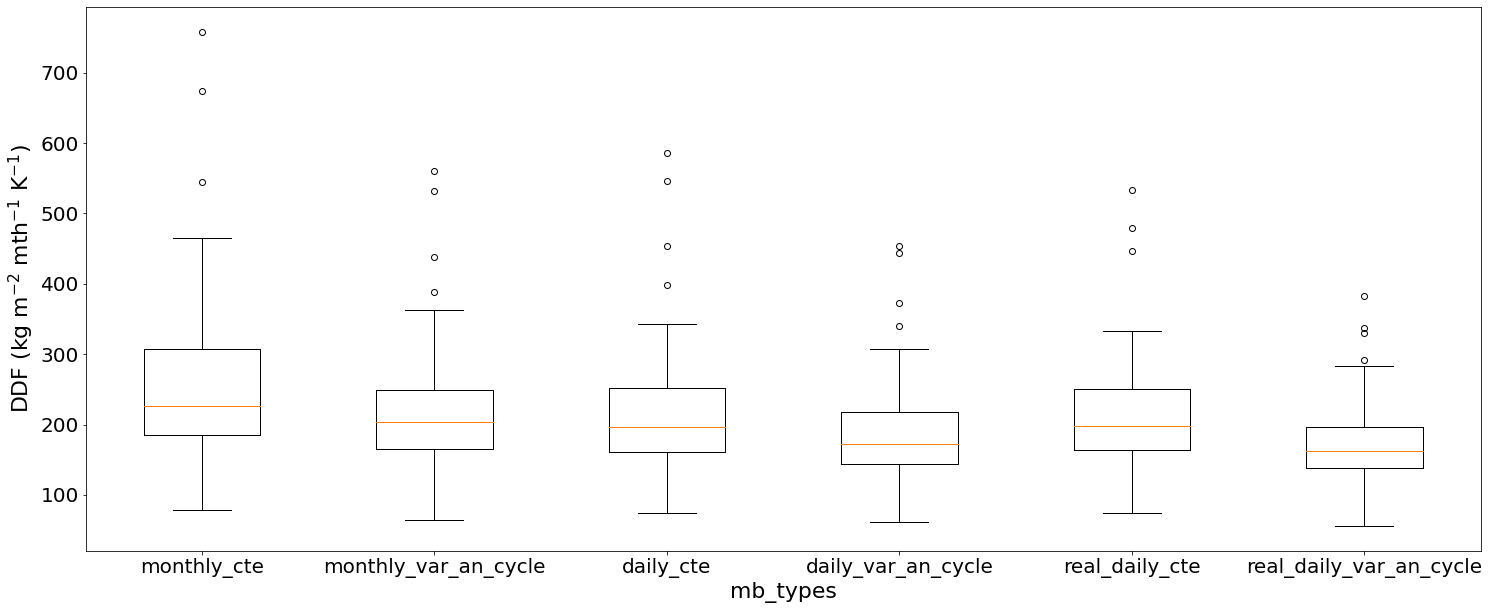

In [8]:
plt.figure(figsize=(25,10))
li_plot = []
li_label = []
for mb_type in ['mb_monthly','mb_daily', 'mb_real_daily']: #,'mb_real_daily']:
        for grad in ['cte','var_an_cycle']:
            li_plot.append(pd_mb_data['DDF_opt_{}_{}'.format(mb_type,grad)][~np.isnan(pd_mb_data['DDF_opt_{}_{}'.format(mb_type,grad)])])
            li_label.append(mb_type[3:]+'_'+grad)
plt.boxplot(li_plot, labels =li_label)
plt.ylabel('DDF (kg m$^{-2}$ mth$^{-1}$ K$^{-1}$)') 
plt.xlabel('mb_types')
plt.savefig('./figures_alps/alps_6mbtypes_DDF.pdf')

- a more complicated mass balance module resutls in DDF that are lower 
    - if not a cte gradient is used anymore, the lapse rate is different resulting in smaller DDFs
    - if std (daily_cte) or real daily temperature data are used, the DDF is smaller because even for months with no temperatures above the threshold, 
        melting occurs ... 

### 2. Performance measures

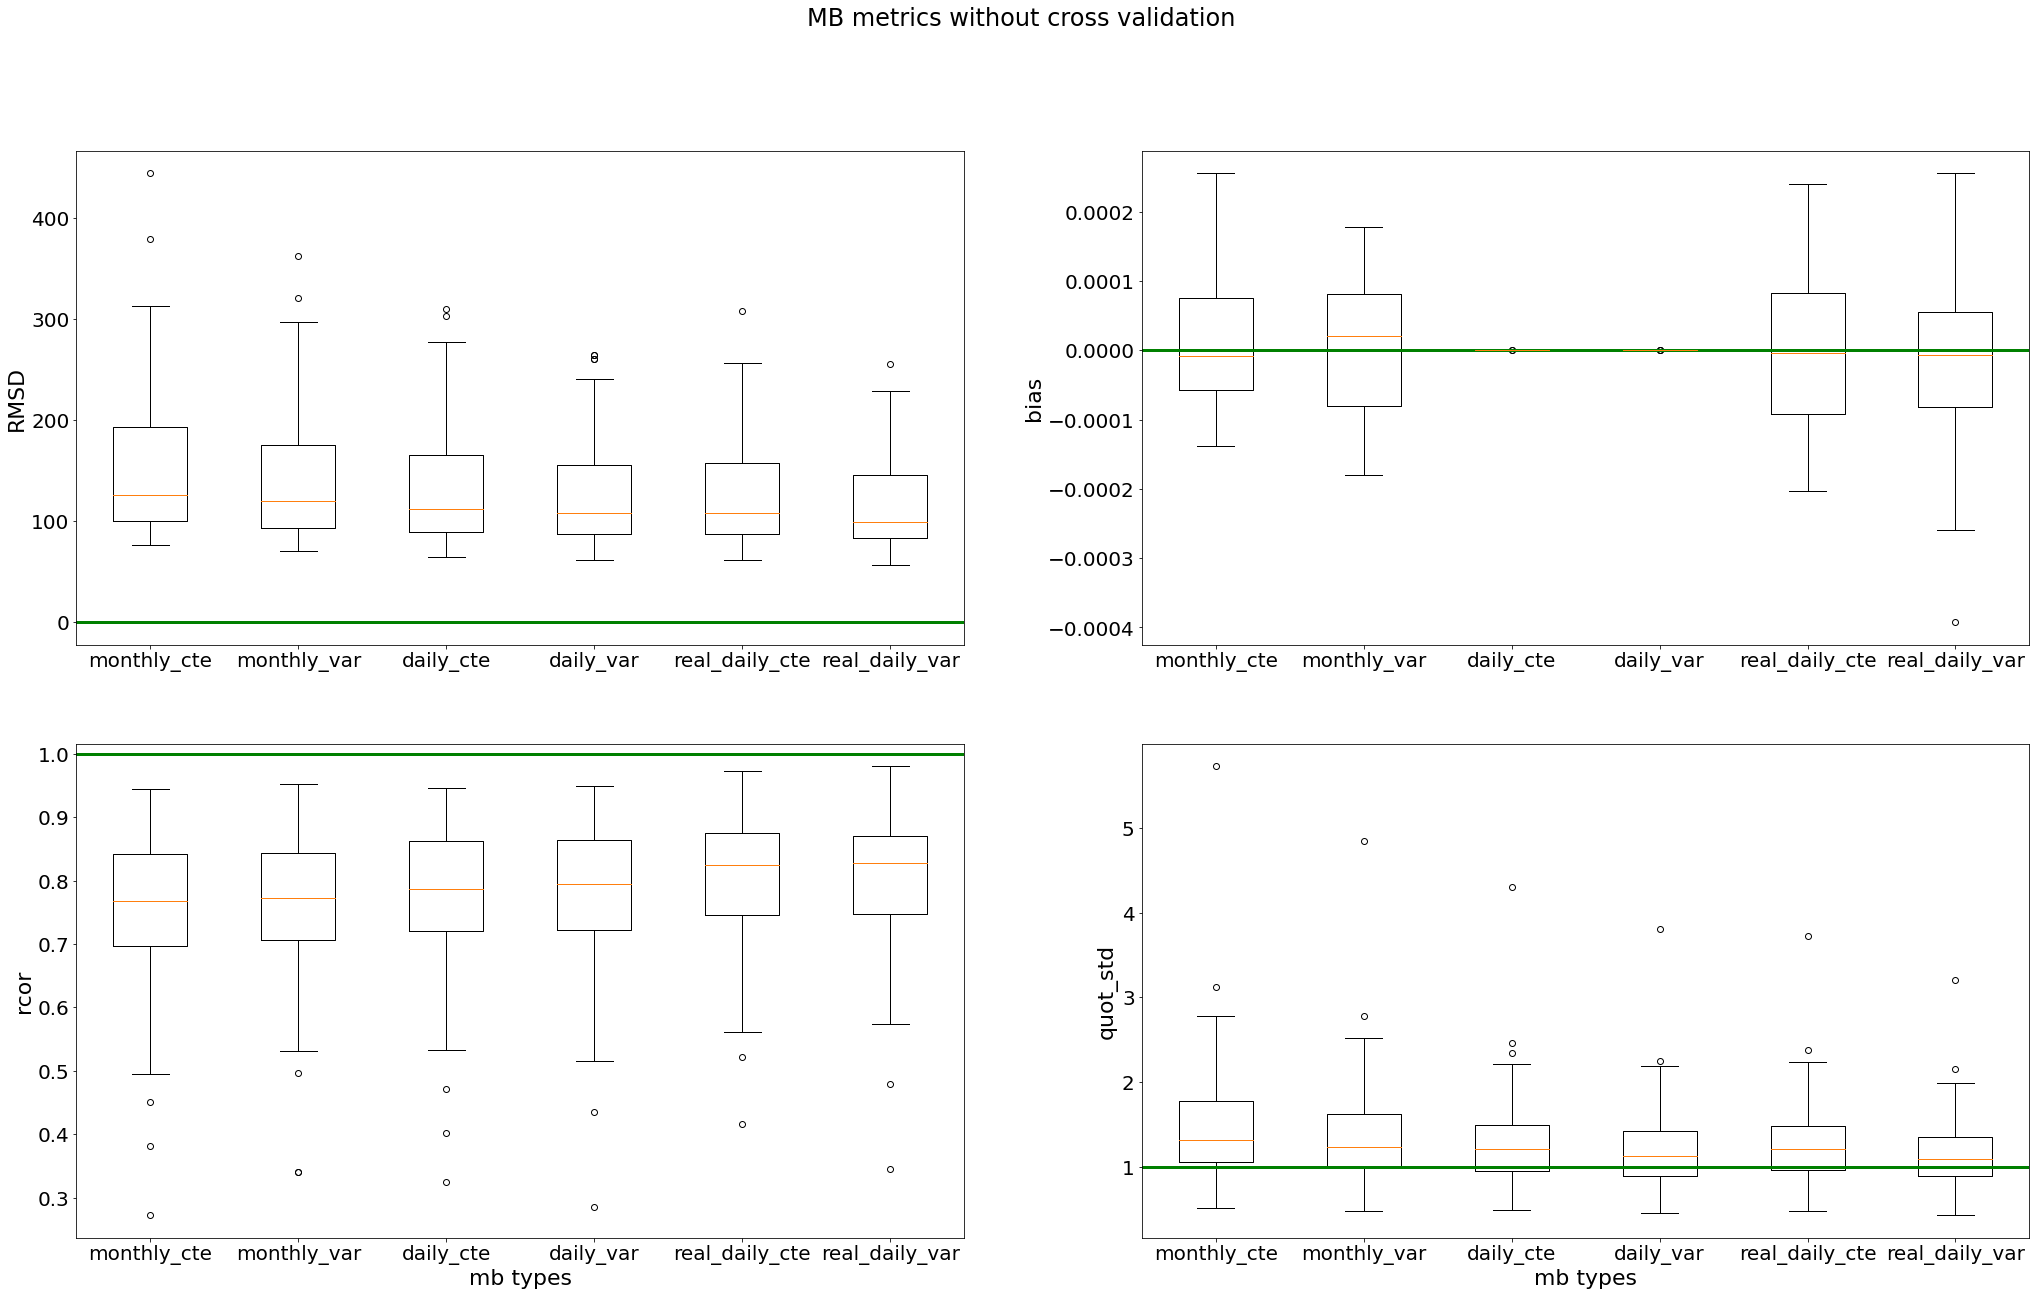

In [9]:
plt.figure(figsize=(35,20))
plt.suptitle('MB metrics without cross validation')
for f, stats_type in enumerate(['RMSD','bias','rcor','quot_std']):
    plt.subplot(2,2,f+1)
    plt.boxplot([np.array(get_stats(stat = stats_type, mb_type = 'mb_monthly', grad_type = 'cte')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_monthly', grad_type = 'var_an_cycle')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_daily', grad_type = 'cte')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_daily', grad_type = 'var_an_cycle')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_real_daily', grad_type = 'cte')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_real_daily', grad_type = 'var_an_cycle')),
                ],
                labels = ['monthly_cte', 'monthly_var','daily_cte', 'daily_var', 'real_daily_cte', 'real_daily_var'])
    plt.ylabel(stats_type)
    plt.xticks()
    if f >1:
        plt.xlabel('mb types')
    #if stats_type =='RMSD':
    #    plt.ylim([-10,500])
    #if stats_type =='std_quot':
    #    plt.ylim([-0.1,4])
    if (stats_type =='RMSD') or (stats_type =='bias'):
        plt.axhline(0, lw=3, color='green')
    if (stats_type =='rcor') or (stats_type =='quot_std'):
        plt.axhline(1, lw=3, color='green')
plt.savefig('./figures_alps/stats_one_flowline_N_{}_59Alps_refglaciers_var_6mb_types_with_mean_an_cycle.pdf'.format(N))

- more complex mb modules seem to perform better (when no cross-validation used)
